In [2]:
import os
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Extract the archive
zip_ref = zipfile.ZipFile("/content/archive_2.zip", 'r')
zip_ref.extractall("tmp/")
zip_ref.close()

# Assign training and validation set directories
base_dir = '/content/tmp/brain_tumor_dataset'
train_dir = os.path.join(base_dir, 'train')


# Directory with training yes pictures
train_yes_dir = os.path.join(train_dir, 'yes')

# Directory with training no pictures
train_no_dir = os.path.join(train_dir, 'no')

In [3]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAINING_DIR = "/content/tmp/brain_tumor_dataset/"
train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=False,
      shear_range=0.2,
      zoom_range=0.2,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=30,
                                                    color_mode='rgb',
                                                    class_mode='binary',
                                                    target_size=(220,220))



Found 253 images belonging to 2 classes.


In [4]:
# Preview the Data
images, labels = next(train_generator)
print(images.shape, labels.shape)

(30, 220, 220, 3) (30,)


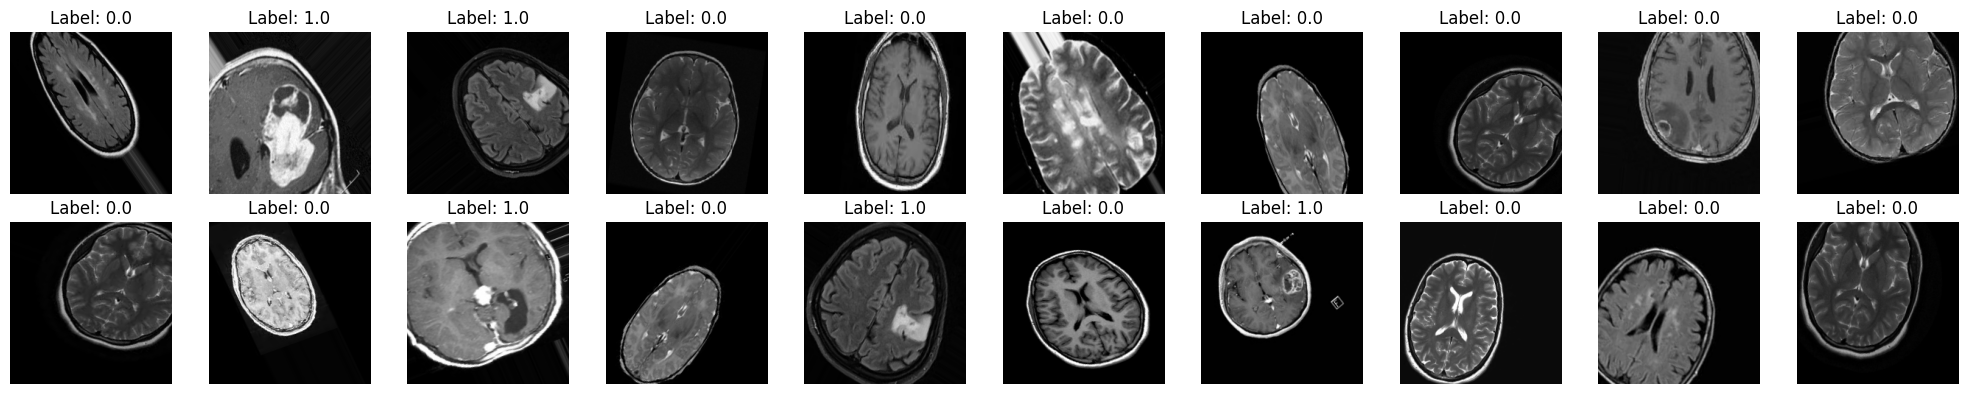

In [5]:
# prompt: plot 20 images form each class on order

import matplotlib.pyplot as plt

# Get a batch of images and labels
images, labels = next(train_generator)

# Create a figure and axes for the plots
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Iterate through the batch of images and labels
for i in range(20):
    # Plot the image on the corresponding axes
    axes[i // 10, i % 10].imshow(images[i])
    axes[i // 10, i % 10].set_title(f"Label: {labels[i]}")
    axes[i // 10, i % 10].axis('off')

# Display the plot
plt.tight_layout()
plt.show()


In [7]:
from tensorflow.keras.applications import MobileNetV2

pre_trained_model = MobileNetV2(
                  input_shape=(220,220, 3),
                  include_top = False,
                  weights = 'imagenet'
              )

for layer in pre_trained_model.layers:
  layer.trainable = False

<ipython-input-7-afb0f6bcc769>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  pre_trained_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
pre_trained_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 220, 220, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 110, 110, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 110, 110, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 110, 110, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 110, 110, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 110, 110, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 110, 110, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 110, 110, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 110, 110, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 110, 110, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 110, 110, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 110, 110, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 111, 111, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 55, 55, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
#Build the Sequential Model
from tensorflow.keras import layers
from tensorflow.keras import Model

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(1, activation='sigmoid')

model = tf.keras.models.Sequential([
    pre_trained_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [10]:
model.compile(optimizer='adam' , loss = 'binary_crossentropy', metrics=['accuracy'])

In [11]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [12]:
history = model.fit(train_generator, epochs=10 , callbacks=[callback] , verbose = 1)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 485ms/step - accuracy: 0.4910 - loss: 5.5870
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.7325 - loss: 1.0341
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.8881 - loss: 0.4302
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.8807 - loss: 0.4147
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.9208 - loss: 0.2600
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.9146 - loss: 0.2433
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.8837 - loss: 0.3113
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.9349 - loss: 0.1918


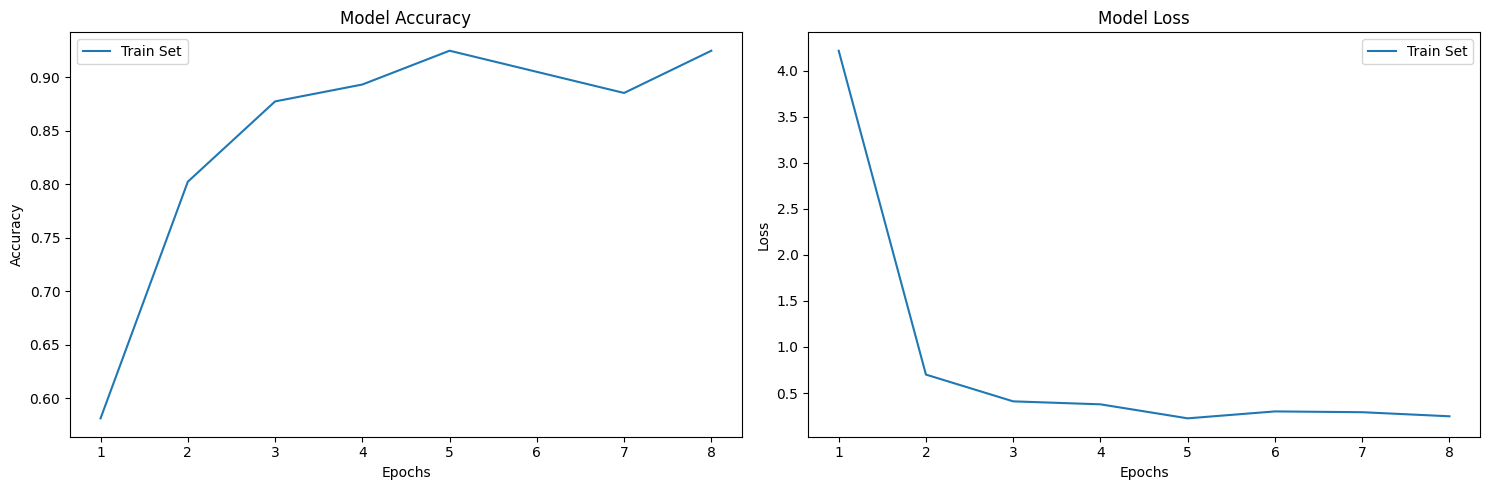

In [13]:
import matplotlib.pyplot as plt
# plot model performance
acc = history.history['accuracy']
loss = history.history['loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [20]:
#predict the class of images ill upload it from my computer

import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(220, 220))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a brain tumor")
  else:
    print(fn + " is not a brain tumor")


Saving bd937738ad6223a03f8aedcf4920a7_big_gallery.jpeg to bd937738ad6223a03f8aedcf4920a7_big_gallery (1).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[0.96680486]
bd937738ad6223a03f8aedcf4920a7_big_gallery (1).jpeg is a brain tumor


In [40]:
from tensorflow.keras.applications import VGG16

vgg_trained_model = VGG16(
                  input_shape=(220,220, 3),
                  include_top = False,
                  weights = 'imagenet'
              )

for layer in vgg_trained_model.layers:
  layer.trainable = False

vgg_trained_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 220, 220, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 220, 220, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 220, 220, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 110, 110, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 110, 110, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 110, 110, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 55, 55, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 55, 55, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 55, 55, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 55, 55, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 27, 27, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 27, 27, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 27, 27, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 27, 27, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 13, 13, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 13, 13, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 13, 13, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 13, 13, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 6, 6, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [41]:
#Build the Sequential Model
from tensorflow.keras import layers
from tensorflow.keras import Model

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(1, activation='sigmoid')

model2 = tf.keras.models.Sequential([
    vgg_trained_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [42]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [43]:
model2.compile(optimizer='adam' , loss = 'binary_crossentropy', metrics=['accuracy'])

In [44]:
Vgg_history = model2.fit(train_generator, epochs=8 , callbacks=[callback] , verbose = 1)

Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 186ms/step - accuracy: 0.5291 - loss: 1.0146
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 0.6053 - loss: 0.8882
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.6041 - loss: 0.9241
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.7425 - loss: 0.6575
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - accuracy: 0.7490 - loss: 0.4979
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.8204 - loss: 0.3889
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.8225 - loss: 0.3745
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.8630 - loss: 0.3295


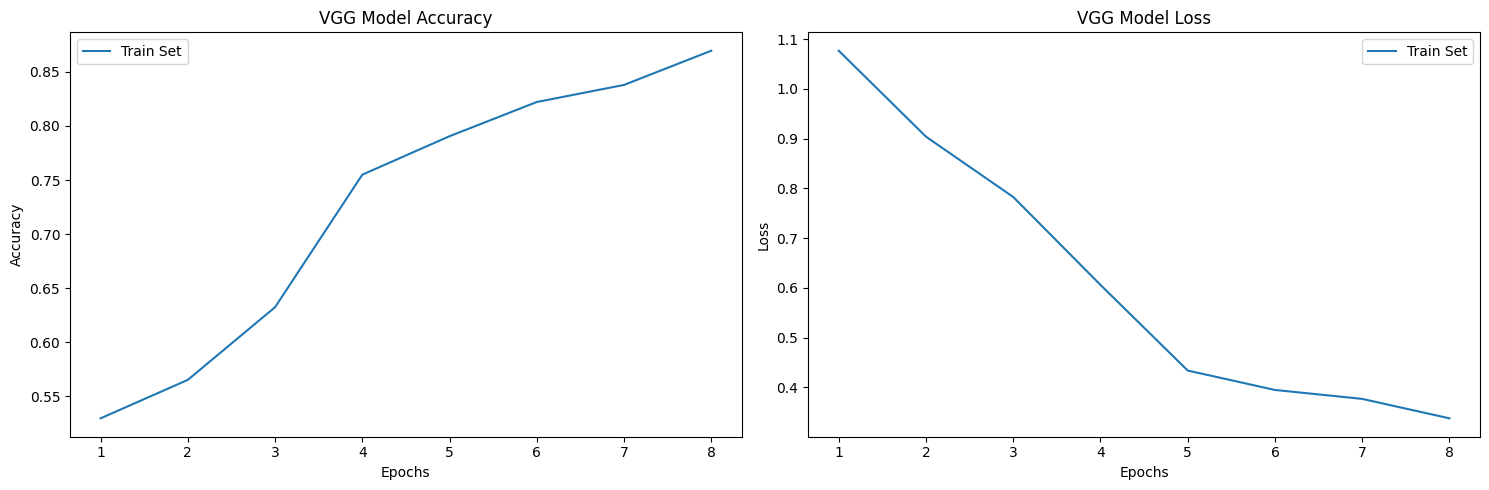

In [45]:
# plot the accuracy and loss for VGG MODEL

import matplotlib.pyplot as plt

# Assuming Vgg_history is the training history object from your model2 training
acc = Vgg_history.history['accuracy']
loss = Vgg_history.history['loss']
epochs_range = range(1, len(Vgg_history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('VGG Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG Model Loss')

plt.tight_layout()
plt.show()


In [46]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

inc_trained_model = InceptionV3(include_top = False,
                                input_shape = (220, 220, 3),
                                weights = 'imagenet')

for layer in inc_trained_model.layers:
  layer.trainable = False

inc_trained_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11            │ (None, 220, 220, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_282 (Conv2D)       │ (None, 109, 109, 32)   │            864 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_282   │ (None, 109, 109, 32)   │             96 │ conv2d_282[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_282            │ (None, 109, 109, 32)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_283 (Conv2D)       │ (None, 107, 107, 32)   │          9,216 │ activation_282[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_283   │ (None, 107, 107, 32)   │             96 │ conv2d_283[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_283            │ (None, 107, 107, 32)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_284 (Conv2D)       │ (None, 107, 107, 64)   │         18,432 │ activation_283[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_284   │ (None, 107, 107, 64)   │            192 │ conv2d_284[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_284            │ (None, 107, 107, 64)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 53, 53, 64)     │              0 │ activation_284[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_285 (Conv2D)       │ (None, 53, 53, 80)     │          5,120 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_285   │ (None, 53, 53, 80)     │            240 │ conv2d_285[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_285            │ (None, 53, 53, 80)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_286 (Conv2D)  

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

In [47]:
#Build the Sequential Model
from tensorflow.keras import layers
from tensorflow.keras import Model

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(1, activation='sigmoid')

model3 = tf.keras.models.Sequential([
    inc_trained_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [48]:
model3.compile(optimizer='adam' , loss = 'binary_crossentropy', metrics=['accuracy'])

In [50]:
inc_history = model3.fit(train_generator, epochs=8 , callbacks=[callback] , verbose = 1)

Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.8420 - loss: 0.3079
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.9011 - loss: 0.2494
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.8706 - loss: 0.2577
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.8964 - loss: 0.2543
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.8347 - loss: 0.3238
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9071 - loss: 0.2207
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.8664 - loss: 0.3754
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.8790 - loss: 0.2722


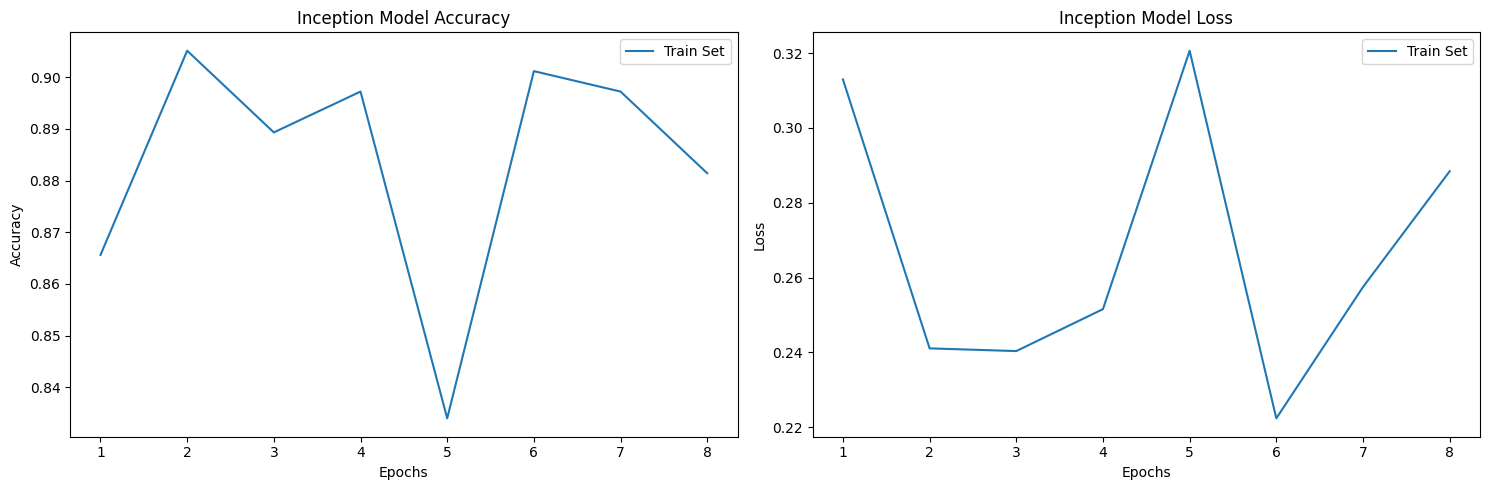

In [51]:
# prompt: plot the accuracy and loss for inception model

import matplotlib.pyplot as plt

# Assuming inc_history is the training history object from your model3 training
acc = inc_history.history['accuracy']
loss = inc_history.history['loss']
epochs_range = range(1, len(inc_history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Inception Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Inception Model Loss')

plt.tight_layout()
plt.show()


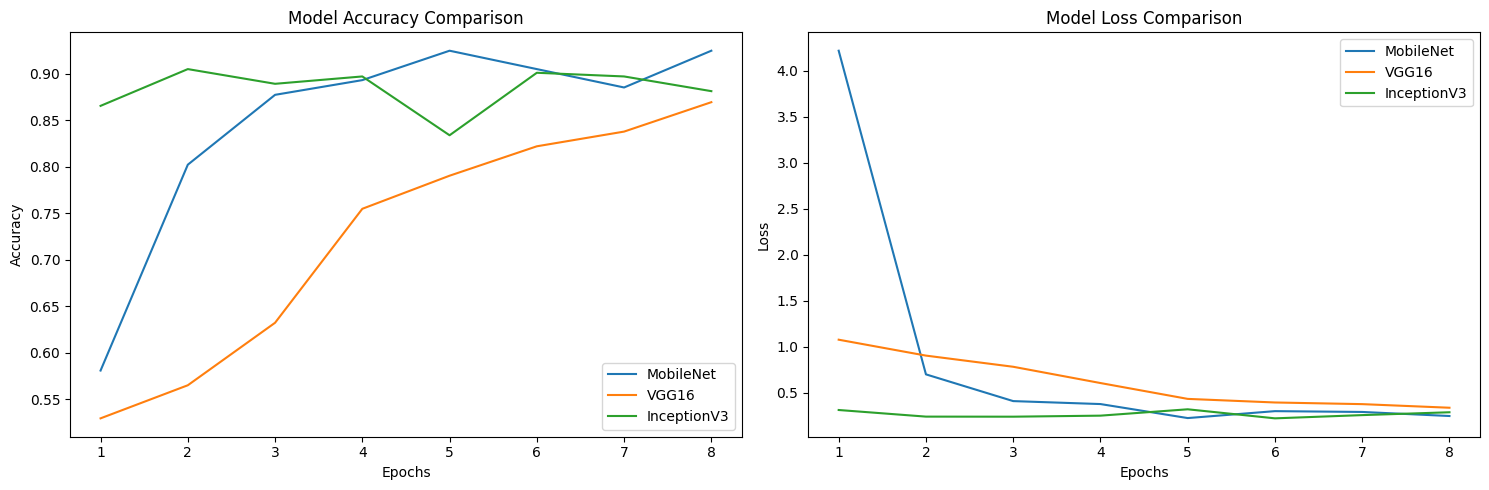

In [52]:
# prompt: # PLOT comparing between mobilenet model and vgg16 model and inception model in accuracy and loss

import matplotlib.pyplot as plt

# Assuming history, Vgg_history, and inc_history are your training history objects
acc_mobilenet = history.history['accuracy']
loss_mobilenet = history.history['loss']
acc_vgg = Vgg_history.history['accuracy']
loss_vgg = Vgg_history.history['loss']
acc_inception = inc_history.history['accuracy']
loss_inception = inc_history.history['loss']

epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_mobilenet, label='MobileNet')
plt.plot(epochs_range, acc_vgg, label='VGG16')
plt.plot(epochs_range, acc_inception, label='InceptionV3')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_mobilenet, label='MobileNet')
plt.plot(epochs_range, loss_vgg, label='VGG16')
plt.plot(epochs_range, loss_inception, label='InceptionV3')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss Comparison')

plt.tight_layout()
plt.show()


Final Accuracy:
MobileNet: 0.9249011874198914
VGG16: 0.8695651888847351
InceptionV3: 0.8814229369163513

The best performing model is: MobileNet with an accuracy of: 0.9249011874198914


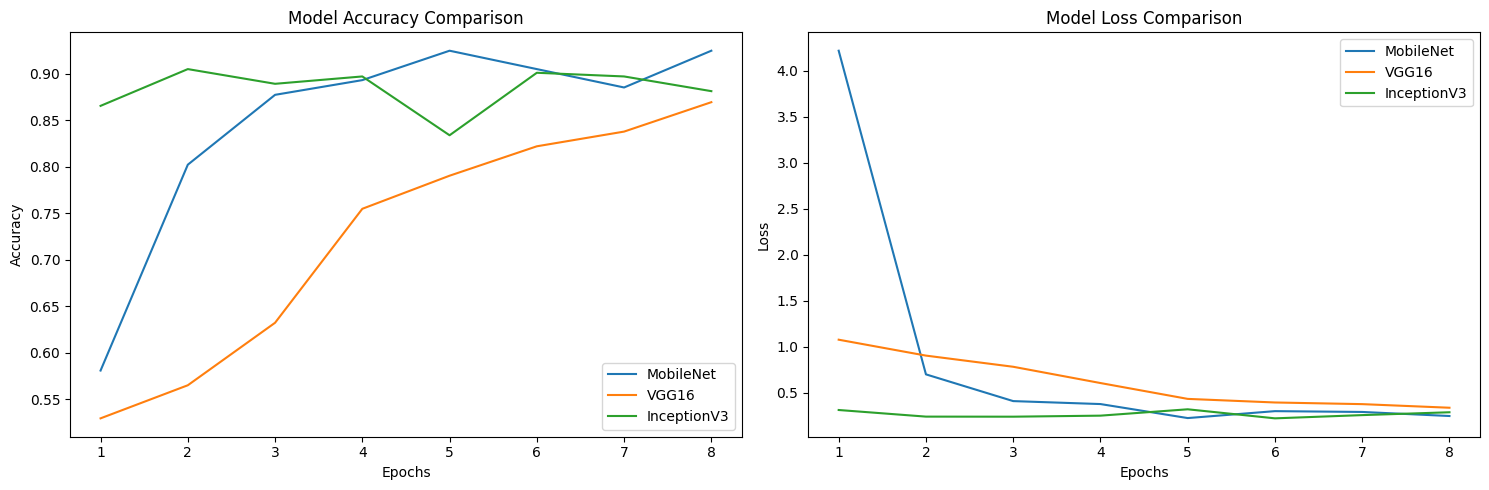

In [53]:
# prompt: give me code that tell me which one is better between 3 models

import matplotlib.pyplot as plt

# Assuming history, Vgg_history, and inc_history are your training history objects
acc_mobilenet = history.history['accuracy']
loss_mobilenet = history.history['loss']
acc_vgg = Vgg_history.history['accuracy']
loss_vgg = Vgg_history.history['loss']
acc_inception = inc_history.history['accuracy']
loss_inception = inc_history.history['loss']

# Get the final accuracy for each model
final_acc_mobilenet = acc_mobilenet[-1]
final_acc_vgg = acc_vgg[-1]
final_acc_inception = acc_inception[-1]

# Compare the final accuracies
print("Final Accuracy:")
print("MobileNet:", final_acc_mobilenet)
print("VGG16:", final_acc_vgg)
print("InceptionV3:", final_acc_inception)

# Determine the best model based on final accuracy
best_model = "MobileNet"
best_accuracy = final_acc_mobilenet

if final_acc_vgg > best_accuracy:
    best_model = "VGG16"
    best_accuracy = final_acc_vgg
if final_acc_inception > best_accuracy:
    best_model = "InceptionV3"
    best_accuracy = final_acc_inception


print("\nThe best performing model is:", best_model, "with an accuracy of:", best_accuracy)

# Plot the comparison for visualization
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_mobilenet, label='MobileNet')
plt.plot(epochs_range, acc_vgg, label='VGG16')
plt.plot(epochs_range, acc_inception, label='InceptionV3')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_mobilenet, label='MobileNet')
plt.plot(epochs_range, loss_vgg, label='VGG16')
plt.plot(epochs_range, loss_inception, label='InceptionV3')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss Comparison')

plt.tight_layout()
plt.show()
